**Zhala Sarkawt Othman**

Named Entity Recognition (NER) Model for Turkish Language

# 1. Import Required Libraries

In [15]:
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from spacy.util import minibatch
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import re

# 2. Load and Parse CoNLL Dataset

In [16]:
def load_conll_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.read().splitlines()

    examples = []
    tokens = []
    labels = []

    for line in lines:
        if line.strip() == '':
            if tokens:
                examples.append((tokens, labels))
                tokens = []
                labels = []
        else:
            parts = line.split()
            if len(parts) >= 2:
                tokens.append(parts[0])
                labels.append(parts[-1])

    return examples

examples = load_conll_data('/content/sample_data/veriseti.conll')

print(f"Loaded {len(examples)} sentences")

Loaded 38 sentences


# 3. Convert Data to spaCy Format

In [17]:
def convert_to_spacy_format_fixed(examples):
    data = []
    for tokens, tags in examples:
        text = ""
        entities = []
        start = 0
        for token, tag in zip(tokens, tags):
            if text:
                text += " "
                start += 1
            token_start = start
            text += token
            token_end = start + len(token)

            if tag != "O":
                label = tag.split("-")[-1]
                if tag.startswith("B-"):
                    entities.append([token_start, token_end, label])
                elif tag.startswith("I-") and entities:
                    if entities[-1][2] == label:
                        entities[-1][1] = token_end
            start = token_end
        data.append((text, {"entities": [tuple(ent) for ent in entities]}))
    return data

data = convert_to_spacy_format_fixed(examples)

# Check label distribution
from collections import Counter
label_counter = Counter()
for _, ann in data:
    for start, end, label in ann["entities"]:
        label_counter[label] += 1
label_counter


Counter({'ORG': 12,
         'COUNTRY': 13,
         'AGE': 13,
         'PROFESSION': 32,
         'PERSON': 21,
         'CITY': 26,
         'EMAIL': 6,
         'DATE': 15,
         'PHONE': 5,
         'STREET': 5,
         'URL': 6,
         'ZIP': 4,
         'STATE': 4,
         'FAX': 2,
         'OTHER': 3})

# 4. Train the NER Model

In [6]:
import spacy
from spacy.training import Example
from spacy.util import minibatch
import random

nlp = spacy.blank("tr")
ner = nlp.add_pipe("ner")
for _, ann in data:
    for ent in ann["entities"]:
        ner.add_label(ent[2])
nlp.initialize()

for itn in range(10):
    random.shuffle(data)
    losses = {}
    batches = minibatch(data, size=8)
    for batch in batches:
        texts, annotations = zip(*batch)
        examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in zip(texts, annotations)]
        nlp.update(examples, drop=0.1, losses=losses)
    print(f"Iteration {itn+1}, Loss: {losses['ner']:.3f}")


Iteration 1, Loss: 575.204
Iteration 2, Loss: 552.062
Iteration 3, Loss: 310.687
Iteration 4, Loss: 274.134
Iteration 5, Loss: 208.517
Iteration 6, Loss: 194.541
Iteration 7, Loss: 187.684
Iteration 8, Loss: 149.413
Iteration 9, Loss: 133.376
Iteration 10, Loss: 116.599


# 5. Evaluate Model with Classification Report & Confusion Matrix


📊 Classification Report:
              precision    recall  f1-score   support

         AGE      0.524     1.000     0.688        11
        CITY      0.840     1.000     0.913        21
     COUNTRY      0.667     1.000     0.800        10
        DATE      1.000     0.769     0.870        13
       EMAIL      0.545     1.000     0.706         6
         FAX      0.000     0.000     0.000         2
         ORG      0.500     0.500     0.500        10
       OTHER      0.000     0.000     0.000         3
      PERSON      1.000     1.000     1.000        18
       PHONE      0.000     0.000     0.000         5
  PROFESSION      0.862     0.962     0.909        26
       STATE      0.000     0.000     0.000         4
      STREET      1.000     0.500     0.667         4
         URL      0.000     0.000     0.000         5
         ZIP      0.000     0.000     0.000         3

    accuracy                          0.766       141
   macro avg      0.463     0.515     0.470       141


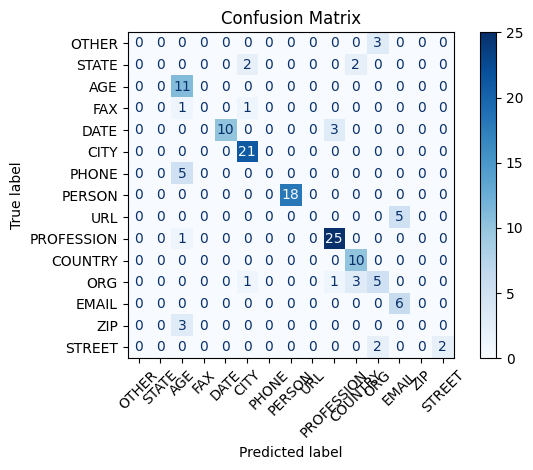

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_entities = []
pred_entities = []

for text, ann in data:
    doc = nlp(text)
    true_labels = [label for _, _, label in ann["entities"]]
    pred_labels = [ent.label_ for ent in doc.ents]

    if len(true_labels) == len(pred_labels):
        true_entities.extend(true_labels)
        pred_entities.extend(pred_labels)

print("\n📊 Classification Report:")
if true_entities and pred_entities:
    report = classification_report(true_entities, pred_entities, digits=3, zero_division=0)
    print(report)

    labels = list(set(true_entities + pred_entities))
    cm = confusion_matrix(true_entities, pred_entities, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No entities found to evaluate.")


# 6. Visualize Sample Predictions

In [20]:

for i in range(3):
    doc = nlp(data[i][0])
    print(f"\nSample {i+1} Text: {doc.text}")
    print("Entities:")
    for ent in doc.ents:
        print(f"  {ent.text} ({ent.label_})")



Sample 1 Text: -DOCSTART-
Entities:

Sample 2 Text: Microsoft Türkiye 'den 35 yaşındaki yazılım mühendisi Ahmet Bey İstanbul 'a taşındı .
Entities:
  Microsoft Türkiye (ORG)
  35 yaşındaki (AGE)
  yazılım mühendisi (AGE)
  Ahmet Bey (PERSON)
  İstanbul (CITY)

Sample 3 Text: Sabancı Üniversitesi 'nden Dr. Fatma Özkan info@sirket.com.tr adresine proje önerisini gönderdi .
Entities:
  Sabancı Üniversitesi (ORG)
  Dr. (PROFESSION)
  Fatma Özkan (PERSON)
  info@sirket.com.tr (EMAIL)
